In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
import general.plotstyle

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 2000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
# file_write(eqb, "equilibrium.pkl")

In [3]:
%matplotlib inline
plt.close("all")

# Run DLS

## Prepare inputs

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1.5e9, # heat flux density at the x point
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.03, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbach("Ar"), # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}


constants = constants_default.copy() # Set settings to default
radios = radios_default.copy() # Set settings to default
constants["qpllu0"] = 1.5e9

## Setup allstores dict

In [7]:
allstores = {}

## Outer

In [26]:
cvar = "density"
design = "SPR45"
side = "ol"
study = "outer"

allstores[study] = {}


for qpllu0 in [2.5e7, 2.5e8, 2.5e9, 2.5e10]:
    print(side)
    d = eqb["SPR45"][side]
    SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 8) # 
    SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
    # SparRange = [0]
    
    constants["qpllu0"] = qpllu0
    
    try: 
        results = LRBv21(constants, radios, d, 
            SparRange, 
            verbosity = 0, control_variable = cvar, 
            Ctol = 1e-3, Ttol=1e-3,
            dynamicGrid = True,
            dynamicGridRefinementRatio = 10,
            zero_qpllt = True)
    
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)
    
    allstores[study][qpllu0] = copy.deepcopy(results)

ol
Solving...0.00...1.87...4.40...7.38...10.70...14.91...21.81...52.10...Complete in 9.0 seconds
ol
Solving...0.00...1.87...4.40...7.38...10.70...14.91...21.81...52.10...Complete in 6.5 seconds
ol
Solving...0.00...1.87...4.40...7.38...10.70...14.91...21.81...52.10...Complete in 7.0 seconds
ol
Solving...0.00...1.87...4.40...7.38...10.70...14.91...21.81...52.10...Complete in 7.4 seconds


In [11]:
allstores["outer"][1e20]["cvar"][0]

7909869052.506335

In [18]:
study = "outer"
for key in allstores[study].keys():
    print(f"{key}: {allstores['outer'][key]['cvar'][0]:.2e}")    

2e+19: 4.53e+08
4e+19: 1.50e+09
8e+19: 5.17e+09


Text(0.5, 1.0, 'Front movement: outer')

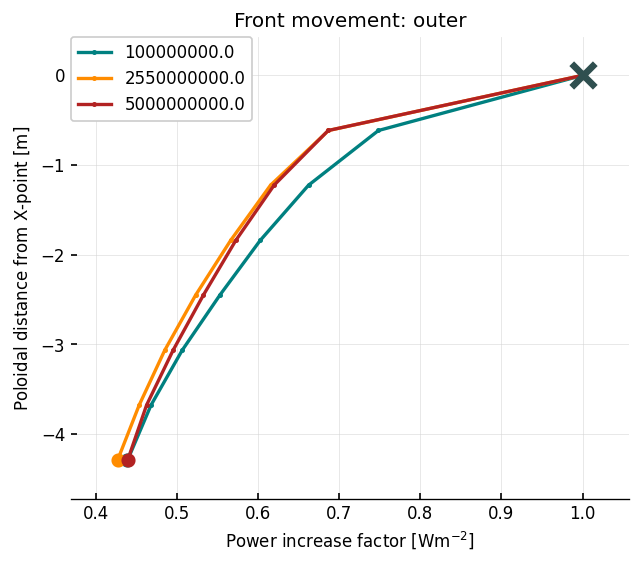

In [25]:
stores = allstores[study]
mode = "outer"

fig, ax = plt.subplots()
style = dict(lw = 2, ms = 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, key in enumerate(stores.keys()):
    s = stores[key]
    # x = s["cvar"]
    x = s["cvar_trim"] / s["cvar_trim"][-1]
    # x = s[f"{cchoice}_trim"]
    y = s["SpolPlot"] - s["SpolPlot"][-1]
    ax.plot(x, y, label = key, color = colors[i], **style, marker = "o")
    
    if i == 0: ax.scatter(x[-1], y[-1], color = "darkslategrey", marker = "x", linewidths = 4, s = 200, zorder = 10)
    ax.scatter(x[0], y[0], color = colors[i], marker = "o", linewidths = 4, s = 20, zorder = 10)
    
    if np.isnan(x).any():
        
        pointx = x[~np.isnan(x)][0]
        ax.plot([pointx, pointx], [y[np.where(x == pointx)[0][0]], y.min()], color = colors[i], linestyle = ":", linewidth = 2)
    
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
# ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
# ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

ax.grid(which = "major", visible = True,   alpha = 0.6)
ax.grid(which = "minor", visible = True,  alpha = 0.3)
if mode == "inner": ax.set_xlim(ax.get_xlim()[::-1])
ax.legend()
ax.set_xlabel("Power increase factor $[Wm^{-2}]$")
ax.set_ylabel("Poloidal distance from X-point $[m]$")
ax.set_title(f"Front movement: {mode}")

# Front traces

Text(0, 0.5, 'Margin')

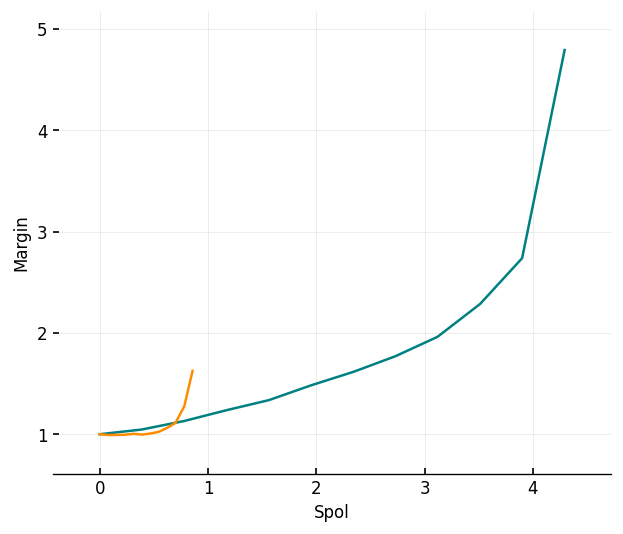

In [40]:
fig, ax = plt.subplots()

for side in ["ol", "il"]:
    store = allstores[side]
    crel = 1/store["crel"]
    
    y = crel[0] / crel
    y = (store["crel"][0] / store["crel"])
    ax.plot(store["SpolPlot"], y)
    
ax.set_xlabel("Spol")
ax.set_ylabel("Margin")



C:\Users\mikek\AppData\Local\Temp\ipykernel_38916\1403006178.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis', 5)


IndexError: list index out of range

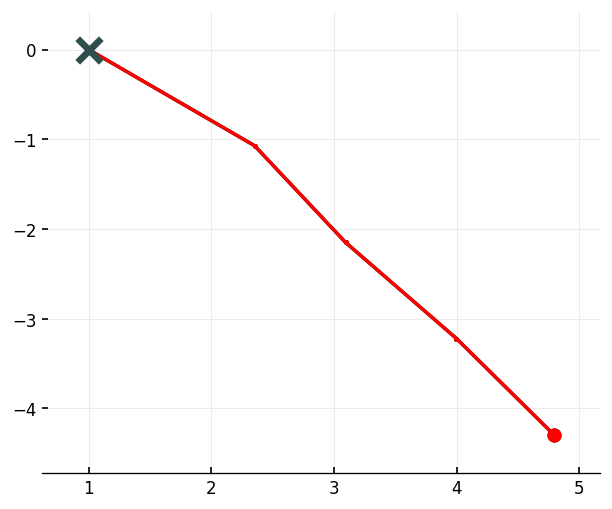

In [23]:
for study in allstores:
    store = allstores[study]
    
    fig, ax = plt.subplots()
    style = dict(lw = 2, ms = 2)

    cmap = mpl.cm.get_cmap('viridis', 5)
    # colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
    colors = ["k", "r"]
    
    for i, id in enumerate(store):
        # s = store[id]
        s = store
        x = s["cvar_trim"] / s["cvar_trim"][-1]
        cchoice = "cvar"
        # x = s[f"{cchoice}_trim"]
        y = s["SpolPlot"] - s["SpolPlot"][-1]
        ax.plot(x, y, color = colors[i], **style, marker = "o")
        
        if i == 0: ax.scatter(x[-1], y[-1], color = "darkslategrey", marker = "x", linewidths = 4, s = 200, zorder = 10)
        ax.scatter(x[0], y[0], color = colors[i], marker = "o", linewidths = 4, s = 20, zorder = 10)
        
        if np.isnan(x).any():
            
            pointx = x[~np.isnan(x)][0]
            ax.plot([pointx, pointx], [y[np.where(x == pointx)[0][0]], y.min()], color = colors[i], linestyle = ":", linewidth = 2)
            
        
    # ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    # ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    # ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.grid(which = "major", visible = True,   alpha = 0.6)
    ax.grid(which = "minor", visible = True,  alpha = 0.3)
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.legend()
    ax.set_xlabel("Power increase factor $[Wm^{-2}]$")
    ax.set_ylabel("Poloidal distance from X-point $[m]$")
    ax.set_title(f"Front movement {study}")
    fig.show()
    # store2.keys()

In [64]:
1.1*1.2

1.32

In [25]:
allstores.keys()

dict_keys([])

In [298]:
key = 1
s  = store_farther_strike[key]
p = profiles_farther_strike[key]
i = 0

Spol = s["Spolprofiles"][i]
S = s["Sprofiles"][i]
Btot = s["Btotprofiles"][i]
Bpol = s["Bpolprofiles"][i]
Xpoint = s["Xpoints"][i]

T = s["Tprofiles"][i]
q = s["Qprofiles"][i]
P = T[-1] * s["state"].nu
N = P/T
R = s["Rprofiles"][i]   # W/m3

st = s["state"]
cvar = s["cvar"][i]
st.qradial

qr_calc = q[Xpoint] / Btot[Xpoint] / np.trapz(1/Btot[Xpoint:], x = S[Xpoint:])
qr_calc = cvar / Btot[Xpoint] / np.trapz(1/Btot[Xpoint:], x = S[Xpoint:])

print(f"qpar at xpoint:  {q[Xpoint]:.2e} W/m2")
print(f"cvar:            {cvar:.2e} W/m2")
print(f"qradial in code: {st.qradial:.2e} W/m2")
print(f"qradial in calc: {qr_calc:.2e} W/m2")

qpar at xpoint:  1.04e+09 W/m2
cvar:            1.33e+09 W/m2
qradial in code: 2.01e+07 W/m2
qradial in calc: 2.01e+07 W/m2


In [215]:
s["cvar"]

array([6.44958938e+09, 2.56543284e+09, 1.44107307e+09, 9.27044032e+08,
       6.04967038e+08])

C:\Users\mikek\AppData\Local\Temp\ipykernel_32280\3979861533.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("viridis", len(s["Spolprofiles"]))(x) for x in range(len(s["Spolprofiles"]))]


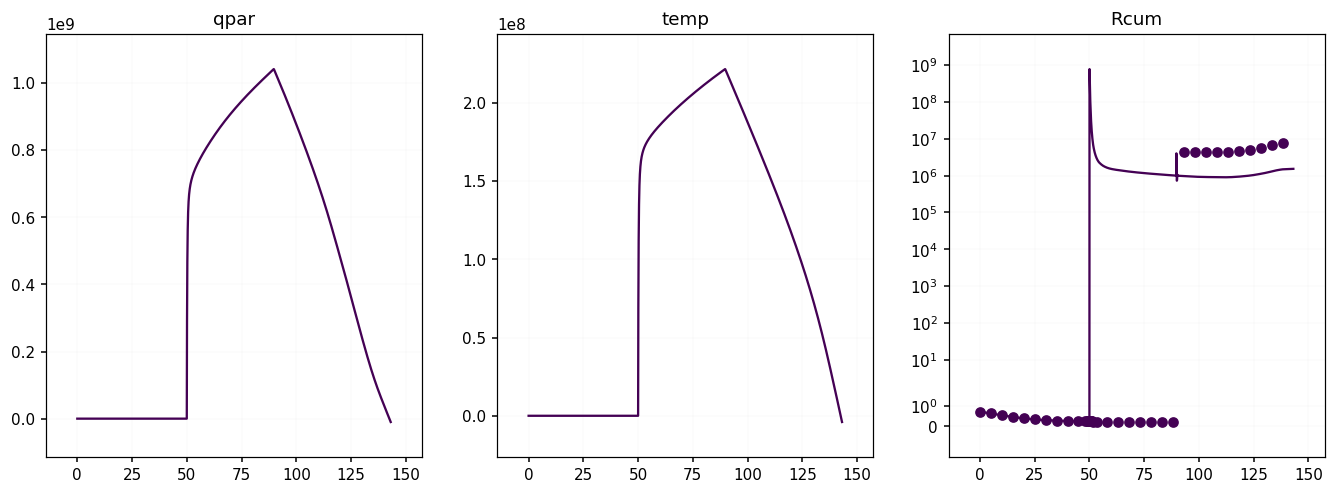

In [299]:
key = 1
s  = store_farther_strike[key]
p = profiles_farther_strike[key]

i = -1


fig, axes = plt.subplots(1,3,figsize=(15,5))

colors = [plt.cm.get_cmap("viridis", len(s["Spolprofiles"]))(x) for x in range(len(s["Spolprofiles"]))]

for i, _ in enumerate(s["Spolprofiles"]):
    i=0
    Spol = s["Spolprofiles"][i]
    S = s["Sprofiles"][i]
    Btot = s["Btotprofiles"][i]
    Bpol = s["Bpolprofiles"][i]
    Xpoint = s["Xpoints"][i]
    
    T = s["Tprofiles"][i]
    q = s["Qprofiles"][i]
    P = T[-1] * s["state"].nu
    N = P/T
    R = s["Rprofiles"][i]   # W/m3
    
    Rcum = sp.integrate.cumulative_trapezoid(y = R, x = S, initial = 0)
    Rcum /= Rcum.max()
    
    Prad = np.gradient(q/Btot, S)   
            
    if s["radios"]["upstreamGrid"] is True:
        # qradial is the uniform upstream heat source
        qradial = np.ones_like(S)
        qradial[Xpoint:] = s["state"].qradial
        Prad += qradial/Btot 
    
    Pradcum = sp.integrate.cumulative_trapezoid(y = Prad, x = S, initial = 0)
    Pradcum /= np.nanmax(Pradcum)

    ax = axes[0]
    ax.plot(S, q, color = colors[i])
    ax.set_title("qpar")
    
    ax = axes[1]
    # ax.plot(S, T, color = colors[i])
    ax.plot(S, q/Btot, color = colors[i])
    ax.set_title("temp")
    
    ax = axes[2]
    ax.plot(S, Prad, color = colors[i])
    ax.plot(S[::50], qradial[::50]/Btot[::50], marker = "o", lw = 0, color = colors[i])
    # ax2 = ax.twinx()
    # ax2.plot(S, np.gradient(Rcum,S), color = colors[i], alpha = 0.3)
    ax.set_yscale("symlog")
    ax.set_title("Rcum")

# Convergence analysis

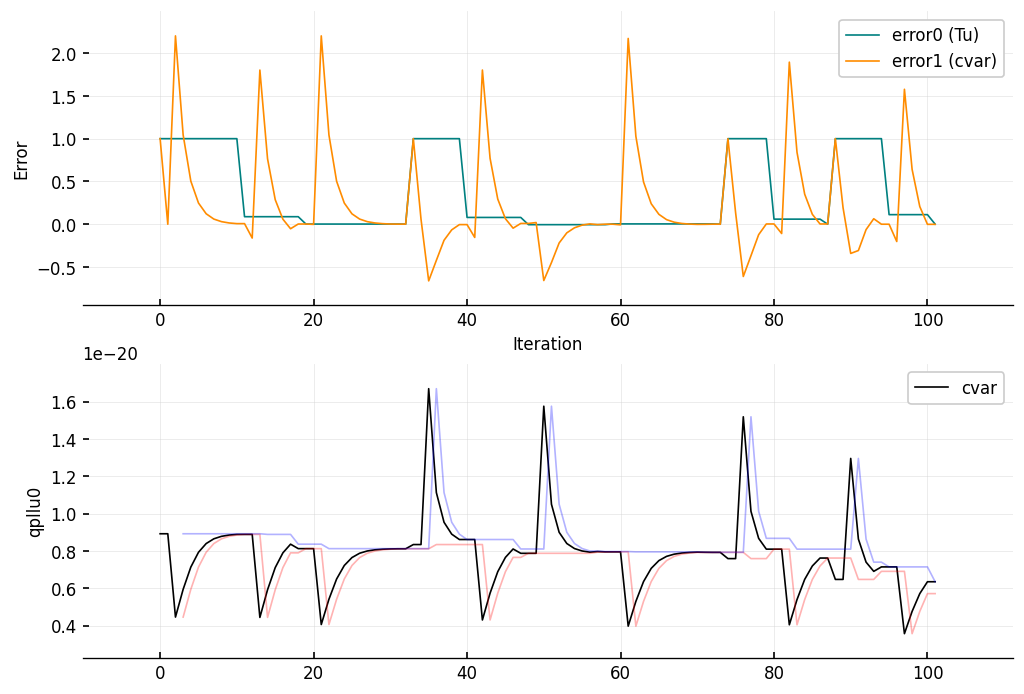

In [55]:


i = 1
logs = allstores["move_in"][i]["logs"]
Svars = list(logs.keys())
log = logs[Svars[0]]

error0 = np.array(log["error0"])
error1 = np.array(log["error1"])

if np.max(error1) > 1e2:
    error1[error1 > np.median(error1)*3] = np.nan

fig, axes = plt.subplots(2,1, figsize = (10,7))
ax = axes[0]
ax.plot(log["error0"], lw = 1,  label = "error0 (Tu)")
ax.plot(error1, lw = 1,  label = "error1 (cvar)")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")

ax = axes[1]
ax.plot(1/np.array(log["cvar"]), color = "k", lw = 1, label = "cvar")
ax.plot(1/np.array(log["upper_bound"]), color = "red", ls = "-", alpha = 0.3, lw = 1)
ax.plot(1/np.array(log["lower_bound"]), color = "blue", ls = "-", alpha = 0.3, lw = 1)
ax.set_ylabel("qpllu0")
ax.legend()


In [ ]:
stores = store_farther_strike
profiles = profiles_farther_strike
for key in stores:
    p = profiles[key]
    s = stores[key]
    plot_profile_histories(p, s, [0,1,2,4], rad_threshold = 0.7, mode = "rad", title = f"Flux expansion = {key}")

# Main results

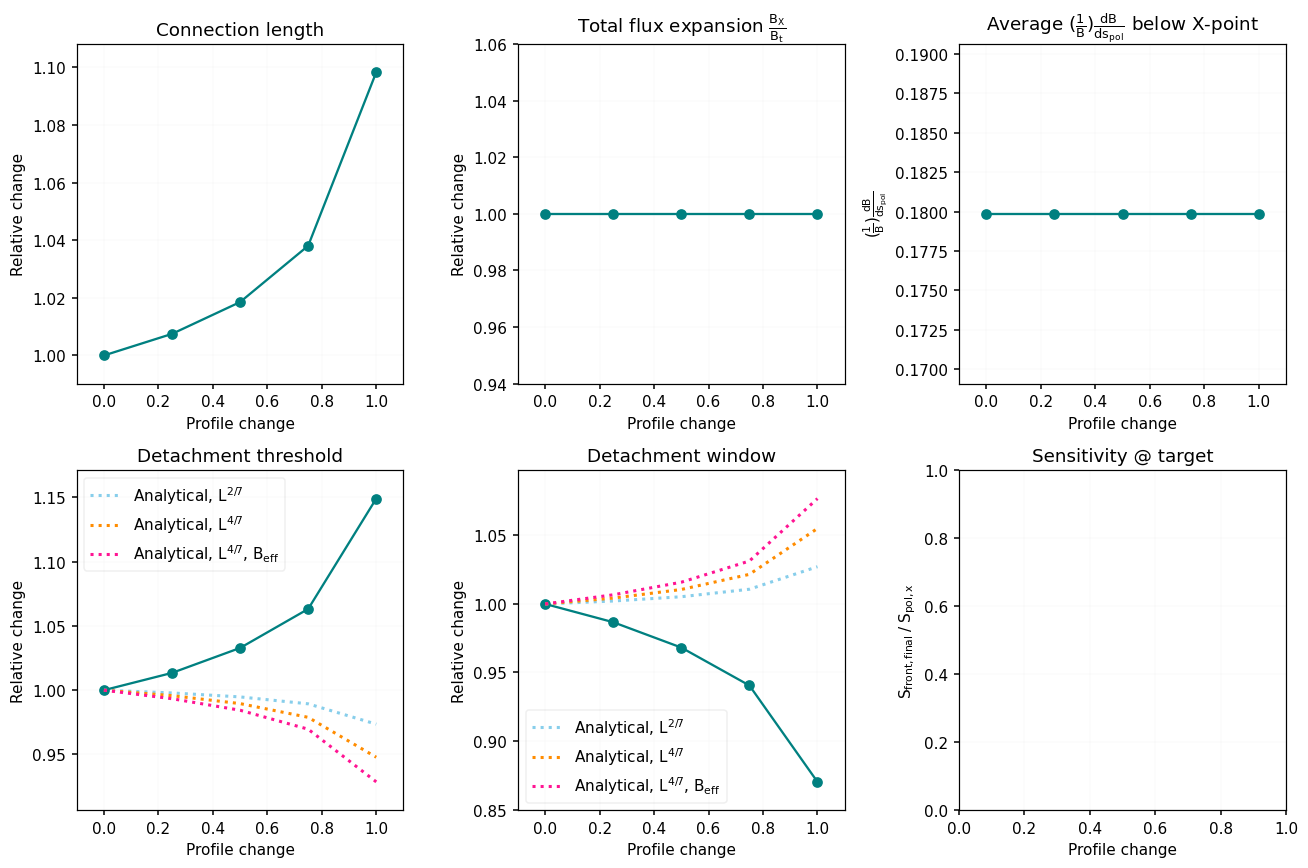

In [454]:
study = "poloidal_flux_expansion"
store = allstores[study]
profile = allprofiles[study]

labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))

windows = np.array([store[x]["window_ratio"] for x in profiles])

thresholds = np.array([store[x]["threshold"] for x in profiles])
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])
front_dfs = [get_front_widths(profiles[x], store[x], Rcutoff = 0.9) for x in profiles]
BxBt_eff = [df["Btot_eff"].iloc[-1] / df["Btot_eff"].iloc[0] for df in front_dfs]

avgB_ratio_eff = []
for df in front_dfs:
    newS = np.linspace(df["Spar"].iloc[0], df["Spar"].iloc[-1], 100)
    Btot_eff_interp = sp.interpolate.make_interp_spline(df["Spar"], df["Btot_eff"])(newS)
    avgB_ratio_eff.append(df["Btot"].iloc[-1] / np.mean(Btot_eff_interp))

# target_sens = np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]
    
threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc3 = (BxBt_eff/BxBt_eff[0])**(-1) * (L/L_base)**(-4/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(2/7)

windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc3 = (BxBt_eff/BxBt_eff[0])**(1) * (L/L_base)**(4/7) * (avgB_ratio_eff/avgB_ratio_eff[0])**(-2/7)

index = profiles.keys()

# index = np.linspace(0,1,5)+i
axes[0,0].set_title("Connection length")
axes[0,0].plot(index, L/L_base, marker = "o")

axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")

axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
axes[0,2].plot(index, frac_gradB, marker = "o")

axes[1,0].set_title(r"Detachment threshold")
axes[1,0].plot(index, thresholds/threshold_base, marker = "o")

lw = 2
axes[1,0].plot(index, threshcalc, lw = lw, color = "skyblue", ls = ":", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,0].plot(index, threshcalc2, lw = lw, color = "darkorange", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,0].plot(index, threshcalc3, lw = lw, color = "deeppink", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$, $B_{eff}$")
axes[1,0].legend(fontsize = "medium")

axes[1,1].set_title(r"Detachment window")
axes[1,1].plot(index, windows/window_base, marker = "o")
axes[1,1].plot(index, windowcalc, lw = lw, color = "skyblue", ls = ":", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,1].plot(index, windowcalc2, lw = lw, color = "darkorange", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,1].plot(index, windowcalc3, lw = lw, color = "deeppink", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$, $B_{eff}$")
axes[1,1].legend(fontsize = "medium")

axes[1,2].set_title(r"Sensitivity @ target")
# axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()

# Capturing impact of gradient

C:\Users\mikek\AppData\Local\Temp\ipykernel_58272\1119466691.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  [plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]


Text(0.5, 1.0, 'Change in front pos for a change in upstream density')

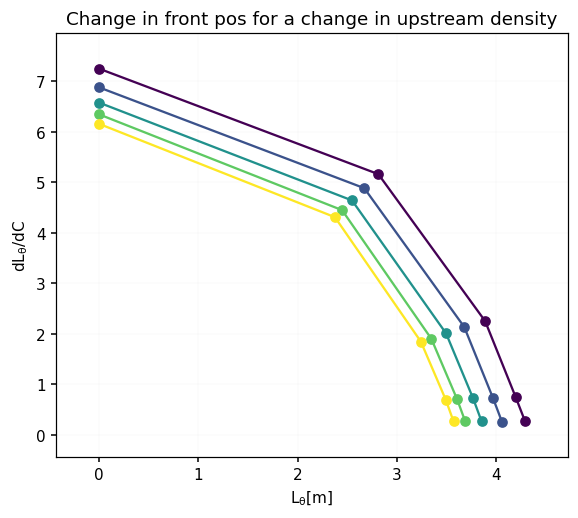

In [55]:
[plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]

fig, ax = plt.subplots()

for i, p in enumerate(profiles):
    s = store[p]
    sens = np.gradient(s["SpolPlot"], s["crel_trim"])
    
    ax.plot(s["SpolPlot"], sens, marker = "o", color = colors[i])
    # ax.plot(store[p]["crel_trim"], store[p]["Splot"], label = p, marker = "o")
    
ax.set_xlabel(r"$L_{\theta} [m]$")
ax.set_ylabel(r"$dL_{\theta} / dC$")
ax.set_title("Change in front pos for a change in upstream density")

In [60]:
profiles

{0.0: <Morph.Profile at 0x20baf125360>,
 0.25: <Morph.Profile at 0x20baed66da0>,
 0.5: <Morph.Profile at 0x20baed65570>,
 0.75: <Morph.Profile at 0x20baed667d0>,
 1.0: <Morph.Profile at 0x20baed64610>}

C:\Users\mikek\AppData\Local\Temp\ipykernel_58272\720109334.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  [plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]


(0.0, 0.4)

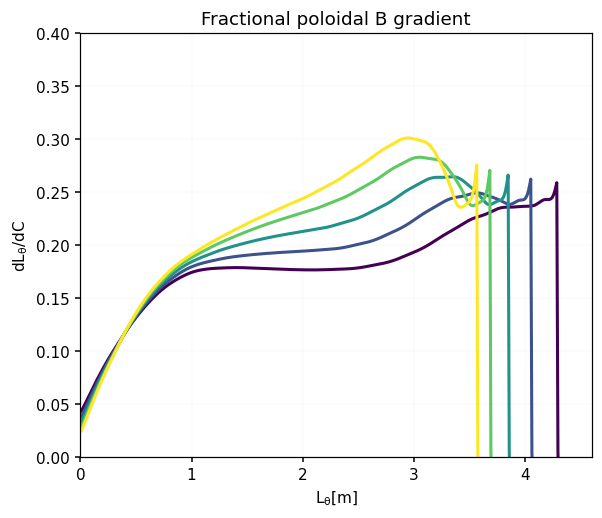

In [72]:
[plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]

fig, ax = plt.subplots()

for i, p in enumerate(profiles):
    s = store[p]
    p = profiles[p]
    Bgrad = np.gradient(p["Btot"], p["Spol"]) / p["Btot"]
    
    ax.plot(p["Spol"], Bgrad, marker = "o", color = colors[i], ms = 0, lw = 2)
    # ax.plot(store[p]["crel_trim"], store[p]["Splot"], label = p, marker = "o")
    
ax.set_xlabel(r"$L_{\theta} [m]$")
ax.set_ylabel(r"$dL_{\theta} / dC$")
ax.set_title("Fractional poloidal B gradient")
ax.set_xlim(0,4.6)
ax.set_ylim(0,0.4)

C:\Users\mikek\AppData\Local\Temp\ipykernel_58272\4144467324.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  [plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]


TypeError: can't multiply sequence by non-int of type 'float'

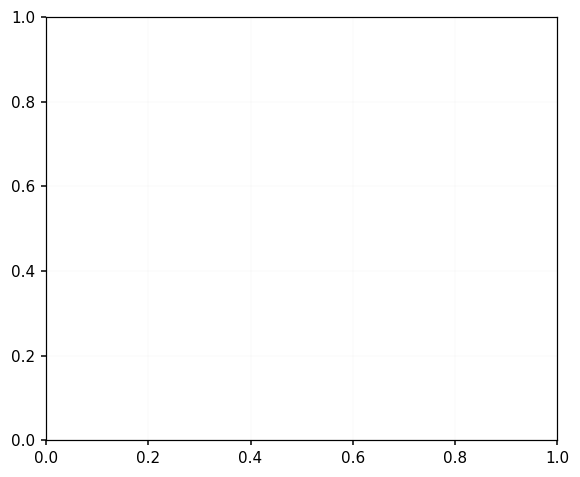

In [91]:
[plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]

fig, ax = plt.subplots()

for i, p in enumerate(profiles):
    s = store[p]
    p = profiles[p]
    Bgrad = np.gradient(p["Btot"], p["Spol"]) / p["Btot"]
    
    ax.plot(p["Spol"],  p["S"] * (7/2) , marker = "o", color = colors[i], ms = 0, lw = 2)
    # ax.plot(store[p]["crel_trim"], store[p]["Splot"], label = p, marker = "o")
    
ax.set_xlabel(r"$L_{\theta} [m]$")
ax.set_ylabel(r"$\frac{2}{7} \ \frac{1}{L_{\parallel,f}} \frac{B_f}{B_{\theta,f}}$", fontsize = 18, rotation = 0, labelpad = 40)
ax.set_title("Magnetic pitch")
ax.set_xlim(0,4.6)
ax.set_ylim(0,0.4)

In [ ]:
[plt.cm.get_cmap("viridis", 5)(x) for x in range(5)]

fig, ax = plt.subplots()

for i, p in enumerate(profiles):
    s = store[p]
    p = profiles[p]
    Bgrad = np.gradient(p["Btot"], p["Spol"]) / p["Btot"]
    
    ax.plot(p["Spol"], (2/7) * p["Bpol"] / (p["S"] * p["Btot"]), marker = "o", color = colors[i], ms = 0, lw = 2)
    # ax.plot(store[p]["crel_trim"], store[p]["Splot"], label = p, marker = "o")
    
ax.set_xlabel(r"$L_{\theta} [m]$")
ax.set_ylabel(r"$\frac{2}{7} \ \frac{1}{L_{\parallel,f}} \frac{B_f}{B_{\theta,f}}$", fontsize = 18, rotation = 0, labelpad = 40)
ax.set_title("Magnetic pitch")
ax.set_xlim(0,4.6)
ax.set_ylim(0,0.4)